# DATA 602 Final Project - Energy Price Predictions

Initial Draft: Connor Trask

In [74]:
#Import necessary modules

from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import scipy as sp
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import plotly.express as px

In [2]:
#Get last 24 hours of price data from ComEd in 5 minute increments
#price_json = requests.get("https://hourlypricing.comed.com/api?type=5minutefeed")
#Get all price data from ComEd for 2023 in 5 minute increments (up to October 1st)
#Datetime format is YYYYMMDDhhmm
price_json = requests.get("https://hourlypricing.comed.com/api?type=5minutefeed&datestart=202301010100&dateend=202310012359")
price_df = pd.read_json(price_json.text)
#time is in millis UTC, price is cents/kWh
price_df.columns = ["time", "price"]
price_df.head()

,time,price
0,1696222500000,1.2
1,1696222200000,1.1
2,1696221900000,0.9
3,1696221600000,1.0
4,1696221300000,1.8


<Axes: xlabel='time', ylabel='price'>

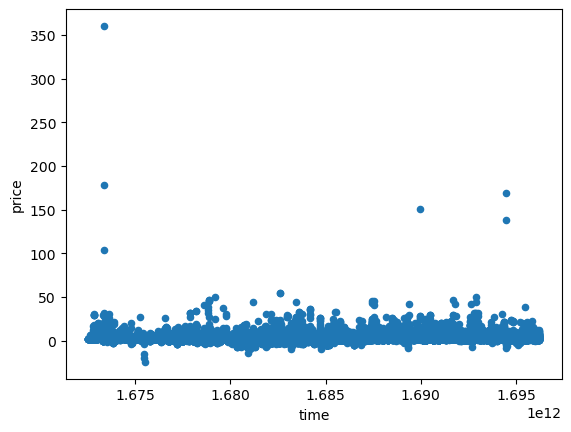

In [3]:
#Exploratory visualization
price_df.plot.scatter("time","price")

<Axes: >

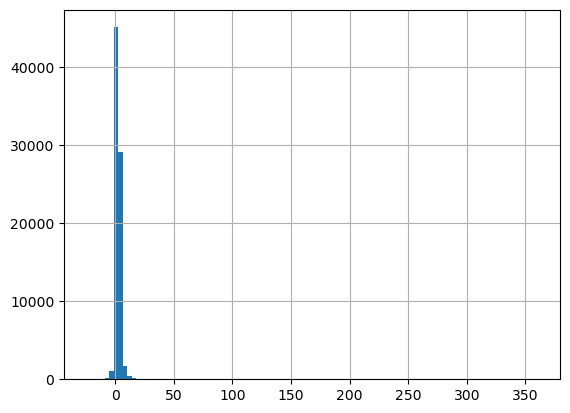

In [4]:
price_df["price"].hist(bins=100)

An exploratory analysis of the price data for 2023 reveals the presence of significant outliers, which make it difficult to observe any patterns in the data. A frequency analysis of the price data reveals that the vast majority of the data is between -10 and 20 cents per kilowatt-hour, so as a result we mask our data to remove any points outside of this range and repeat our visualizations.

<Axes: xlabel='time', ylabel='price'>

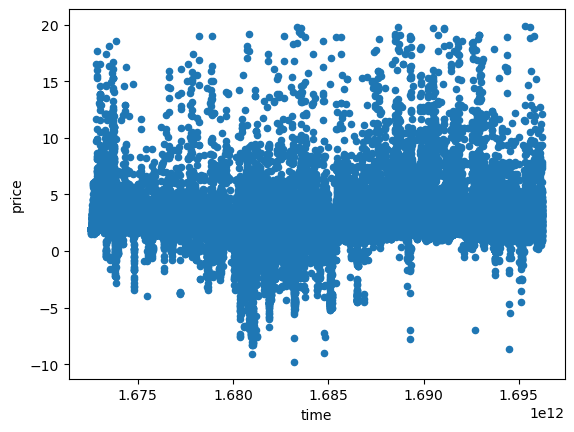

In [5]:
price_df = price_df[(price_df["price"] < 20) & (price_df["price"] > -10)]
price_df.plot.scatter("time","price")

Average price per kilowatt-hour: 2.5915


<Axes: >

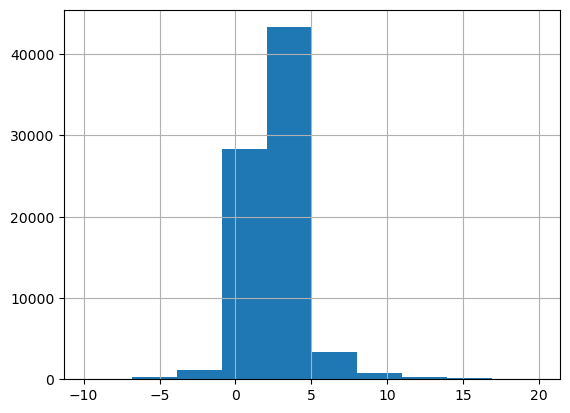

In [6]:
print("Average price per kilowatt-hour: {:.4f}".format(np.mean(price_df["price"])))
price_df["price"].hist()

With this filtered data, we can observe that the data is roughly normally distributed, with a mean of ~2.5 cents/kWh. On the timescale of a year, there is no apparent trend to the data, as price appears to be uniformly distributed over the year. The hope is that patterns will become more present as we reduce our timescale and add additional environmental data, converting our noisy price data into useful predictive data.

In [7]:
price_df["time"] = price_df["time"]/1000
price_df["datetime"] = price_df["time"].apply(datetime.datetime.fromtimestamp)
price_df.head()

,time,price,datetime
0,1.696222e+09,1.2,2023-10-02 00:55:00
1,1.696222e+09,1.1,2023-10-02 00:50:00
2,1.696222e+09,0.9,2023-10-02 00:45:00
3,1.696222e+09,1.0,2023-10-02 00:40:00
4,1.696221e+09,1.8,2023-10-02 00:35:00


In [8]:
price_df["datetime (str)"] = price_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
price_df[['date', 'time']] = price_df['datetime (str)'].str.split(' ', n=1, expand=True)
price_df.head()

,time,price,datetime,datetime (str),date
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02 00:55:00,2023-10-02
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02 00:50:00,2023-10-02
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02 00:45:00,2023-10-02
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02 00:40:00,2023-10-02
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02 00:35:00,2023-10-02


In [9]:
price_df[["year", "month", "day"]] = price_df["date"].str.split("-", n=2, expand=True)
price_df[["hour", "minute", "second"]] = price_df["time"].str.split(":", n=2, expand=True)
price_df.head()

,time,price,datetime,datetime (str),date,year,month,day,hour,minute,second
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02 00:55:00,2023-10-02,2023,10,02,00,55,00
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02 00:50:00,2023-10-02,2023,10,02,00,50,00
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02 00:45:00,2023-10-02,2023,10,02,00,45,00
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02 00:40:00,2023-10-02,2023,10,02,00,40,00
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02 00:35:00,2023-10-02,2023,10,02,00,35,00


In [10]:
#Year and second can both be dropped, since we are currently only looking at 2023 data and our resolution is only 5 minutes
price_df.drop(columns=["year", "second", "datetime (str)"], inplace=True)
price_df.head()

,time,price,datetime,date,month,day,hour,minute
0,00:55:00,1.2,2023-10-02 00:55:00,2023-10-02,10,02,00,55
1,00:50:00,1.1,2023-10-02 00:50:00,2023-10-02,10,02,00,50
2,00:45:00,0.9,2023-10-02 00:45:00,2023-10-02,10,02,00,45
3,00:40:00,1.0,2023-10-02 00:40:00,2023-10-02,10,02,00,40
4,00:35:00,1.8,2023-10-02 00:35:00,2023-10-02,10,02,00,35


While all of the data manipulation steps will remain listed above to provide insight into the thought process behind this data handling, they are condensed into the following function for use later in the project:

In [208]:
def load_price_data(url, upper_limit=20, lower_limit=-10):
    '''Load price data from API to dataframe 
    Input:
        url - (str), API url to extract the data from
        upper_limit - (float), Prices above this value will be considered outliers and removed
        lower_limit - (float), Prices below this value will be considered outliers and removed
    Output:
        price_df - (pandas dataframe), Containing price data broken out by various date/time formats'''
    
    price_json = requests.get(url)
    price_df = pd.read_json(price_json.text)
    #time is in millis UTC, price is cents/kWh
    price_df.columns = ["time", "price"]
    price_df = price_df[(price_df["price"] < upper_limit) & (price_df["price"] > lower_limit)] #Filter outliers
    price_df["time"] = price_df["time"]/1000
    price_df["datetime"] = price_df["time"].apply(datetime.datetime.fromtimestamp)
    price_df["weekday"] = price_df["datetime"].dt.strftime("%a")
    price_df["datetime (str)"] = price_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
    price_df[['date', 'time']] = price_df['datetime (str)'].str.split(' ', n=1, expand=True)
    price_df[["year", "month", "day"]] = price_df["date"].str.split("-", n=2, expand=True)
    price_df[["hour", "minute", "second"]] = price_df["time"].str.split(":", n=2, expand=True)
    price_df.drop(columns=["second", "datetime (str)"], inplace=True)
    price_df["decimal time"] = price_df["hour"].astype(int) + price_df["minute"].astype(float)/60
    price_df[["year","month","day","hour","minute"]] = price_df[["year","month","day","hour","minute"]].astype(int) #Convert columns from strings to int
    return price_df

<Axes: xlabel='datetime', ylabel='price'>

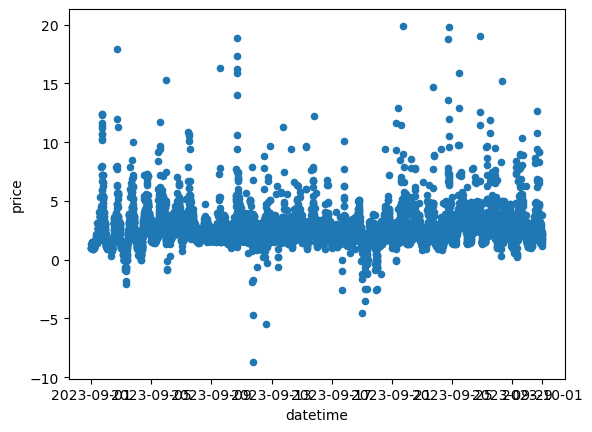

In [12]:
september_data = price_df[price_df["month"] == "09"]
september_data.plot.scatter("datetime","price")

<Axes: xlabel='datetime', ylabel='price'>

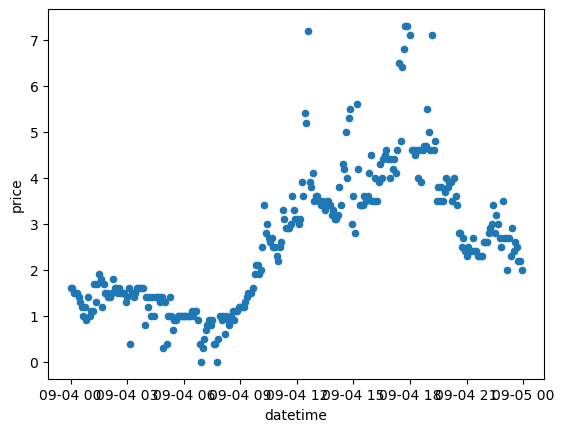

In [13]:
single_day = price_df[(price_df["month"] == "09") & (price_df["day"] == "04")]
single_day.plot.scatter("datetime", "price")

While there is no clear pattern in the price data at the year or month level, we can see a clear sinusoidal pattern emerge at the day scale. As expected, Energy prices are low late at night into the morning (approximately Midnight to 9 am), before increasing up to the daily peak (approximately noon to 6 pm), then declining back down in the evening. 

## Fitting Daily Model

<Axes: xlabel='decimal time', ylabel='price'>

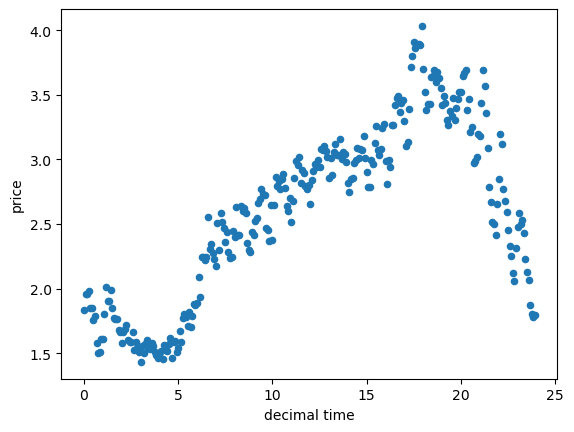

In [14]:
#Create decimal time column and groupby on it for curve fitting
price_df["decimal time"] = price_df["hour"].astype(int) + price_df["minute"].astype(float)/60
day_df = price_df.groupby(["decimal time"], as_index=False).mean()
day_df.plot.scatter("decimal time","price")

Standard Error of Regression: 0.2662


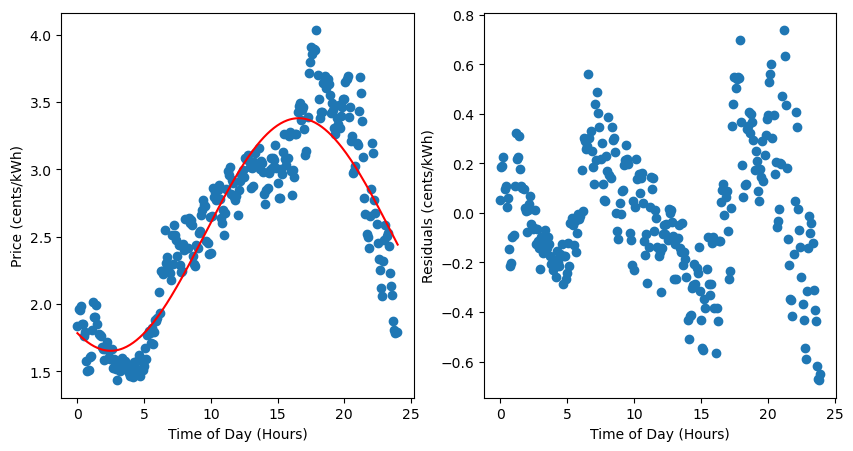

In [15]:
def sin(x,a,b,c,d):
    return a*np.sin(b*(x+c)) + d

cof, cov = sp.optimize.curve_fit(sin, day_df["decimal time"], day_df["price"], [-1.25,0.25,0,2.5])
x = np.linspace(0,24,288)
p_x = sin(x, *cof) #Predicted values (p(x))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r")
plt.scatter(day_df["decimal time"], day_df["price"])
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
#R-squared not valid for nonlinear model, use standard error of regression instead
residuals = day_df["price"] - p_x
plt.subplot(122)
plt.scatter(day_df["decimal time"], residuals)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Residuals (cents/kWh)")
print("Standard Error of Regression: {:.4f}".format((np.sum(residuals**2)/(len(residuals)-2))**0.5))

We can see from the above plot that fitting a simple sine function to the daily date does a good job capturing the pattern of data consumption throughout the day. Our residuals appear to show an additional sinusoidal pattern, which we will attempt to capture with an additional sinusoidal function. 

In [76]:
def adv_sinusoid(x,a,b,c,d,e,f,g,h):
    return (a*np.sin(b*(x+c)) + d) + (x*e*np.sin(f*(x+g)) + h)

cof, cov = sp.optimize.curve_fit(adv_sinusoid, day_df["decimal time"], day_df["price"], [-1.25,0.25,0,2.5,0.03,0.65,1,0])
x = np.linspace(0,24,288)
p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
residuals = day_df["price"] - p_x
standard_error = (np.sum(residuals**2)/(len(residuals)-2))**0.5
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r", label="Predicted Price")
plt.fill_between(x, p_x + 2*standard_error, p_x - 2*standard_error, alpha=0.5, label="95% CI", color="tab:orange")
plt.scatter(day_df["decimal time"], day_df["price"],color="tab:blue", label="Actual Price")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
plt.legend()
#R-squared not valid for nonlinear model, use standard error of regression instead
plt.subplot(122)
plt.scatter(day_df["decimal time"], residuals)
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Residuals (cents/kWh)")

print("Standard Error of Regression: {:.4f}".format(standard_error))

NameError: name 'day_df' is not defined

We can see that the addition of this linear sinsuoid term to our base model greatly improves its fit, reducing the standard error of the regression, the maximum residual value, and removing any clear pattern from our residuals, leaving them randomly distributed. By applying the standard error, we can see that approximately 95% of our data points are within a range of +/- 0.36 cents/kWh from our model's prediction.

### Testing Simple Daily Model

Now that we have a model for the average fluctuations in electricity price over the course of a day, we will apply it to our data to evaluate how well it performs for a given day. In order to prevent our model from "training to the test", we will test on a subset of days selected outside the range of days our training data was drawn from. 

In [17]:
test_df = load_price_data("https://hourlypricing.comed.com/api?type=5minutefeed&datestart=202310020100&dateend=202310172359")
test_df.head()

,time,price,datetime,date,month,day,hour,minute,decimal time
0,00:55:00,2.7,2023-10-18 00:55:00,2023-10-18,10,18,00,55,0.916667
1,00:50:00,2.1,2023-10-18 00:50:00,2023-10-18,10,18,00,50,0.833333
2,00:45:00,3.2,2023-10-18 00:45:00,2023-10-18,10,18,00,45,0.750000
3,00:40:00,3.1,2023-10-18 00:40:00,2023-10-18,10,18,00,40,0.666667
4,00:35:00,3.5,2023-10-18 00:35:00,2023-10-18,10,18,00,35,0.583333


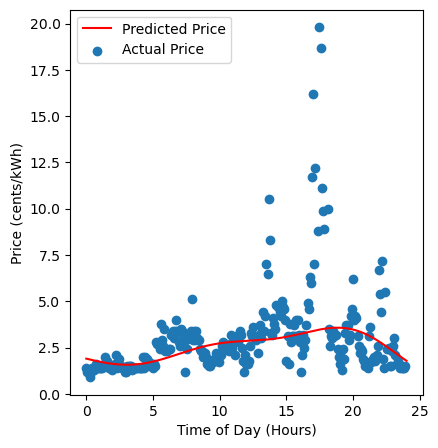

In [18]:
test_day_df = test_df[test_df["day"] == "03"]
x = np.linspace(0,24,288) #288 5-minute samples in a day
p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r", label="Predicted Price")
plt.scatter(test_day_df["decimal time"], test_day_df["price"], label="Actual Price")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
plt.legend()

In [19]:
error = 0
n = 0
for i in range(2,18):
    test_day_df = test_df[test_df["day"].astype(int) == i]
    x = np.linspace(0,24,len(test_day_df["price"])) #288 5-minute samples in a day, but some are removed as outliers
    p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
    residuals = test_day_df["price"] - p_x
    error += np.sum(residuals**2)
    n += len(residuals)
    
print("Testing Data Standard Error of Regression: {:.4f}".format((error/(n-2))**0.5))

Testing Data Standard Error of Regression: 2.1911


We can see from the above standard error and exploratory plots that despite our model performing excellently on the averaged price data, it does not generalize well to predicting prices for individual days, due to the massive price variance day-to-day. While we were able to accurately predicted prices within +/- 0.36 cents/kWh on the averaged data, we are only able to predict prices within +/- 4.4 cents/kWh on the testing data, which represents nearly the entire range of the data. We aim to incorporate weather data to account for this day-to-day variance and reduce our model's error.

Standard Error of Regression: 0.7194


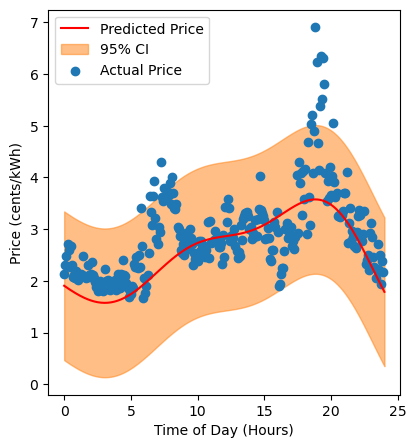

In [20]:
test_day_df = test_df.groupby(["decimal time"], as_index=False).mean()
x = np.linspace(0,24,288) #288 5-minute samples in a day
p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
residuals = test_day_df["price"] - p_x
standard_error = (np.sum(residuals**2)/(len(residuals)-2))**0.5 #Need more research on CI formula

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(x, p_x,"r", label="Predicted Price")
plt.fill_between(x, p_x + 2*standard_error, p_x - 2*standard_error, alpha=0.5, label="95% CI", color="tab:orange")
plt.scatter(test_day_df["decimal time"], test_day_df["price"], label="Actual Price", color="tab:blue")
plt.xlabel("Time of Day (Hours)")
plt.ylabel("Price (cents/kWh)")
plt.legend()

print("Standard Error of Regression: {:.4f}".format(standard_error))

If we average our testing data (17 days) and then apply our model, we can see that it performs better than predicting on a day-by-day basis (+/- 1.4 cents/kWh instead of +/- 4.2 cents/kWh), but still significantly worse than our training set (+/- 0.36 cents/kWh). A visual inspection of this averaged testing data reveals that our model does accurately predict the general shape of the data, but fails to account for significant spikes around 7AM and 7PM.

# Final Project

## 1) Gather Historical Price Data 

In [154]:
#Get all price data from 2019-2022 to create a historical baseline for the model
#API call is a bit weird, the call below has been confirmed correct by checking historical_data.head() and .tail()
historical_data = load_price_data("https://hourlypricing.comed.com/api?type=5minutefeed&datestart=201812312259&dateend=202212312259")
historical_data

,time,price,datetime,weekday,date,year,month,day,hour,minute,decimal time
0,23:55:00,2.0,2022-12-31 23:55:00,Sat,2022-12-31,2022,12,31,23,55,23.916667
1,23:50:00,2.0,2022-12-31 23:50:00,Sat,2022-12-31,2022,12,31,23,50,23.833333
2,23:45:00,2.1,2022-12-31 23:45:00,Sat,2022-12-31,2022,12,31,23,45,23.750000
3,23:40:00,2.1,2022-12-31 23:40:00,Sat,2022-12-31,2022,12,31,23,40,23.666667
4,23:35:00,2.1,2022-12-31 23:35:00,Sat,2022-12-31,2022,12,31,23,35,23.583333
...,...,...,...,...,...,...,...,...,...,...,...
414452,00:20:00,1.8,2019-01-01 00:20:00,Tue,2019-01-01,2019,1,1,0,20,0.333333
414453,00:15:00,1.8,2019-01-01 00:15:00,Tue,2019-01-01,2019,1,1,0,15,0.250000
414454,00:10:00,1.7,2019-01-01 00:10:00,Tue,2019-01-01,2019,1,1,0,10,0.166667
414455,00:05:00,1.7,2019-01-01 00:05:00,Tue,2019-01-01,2019,1,1,0,5,0.083333


## 2) Train Month & Weekday Models 

In [184]:
prediction_dict = dict()
month_cofs = dict()
weekday_cofs = dict()
for month in range(1,13):
    #Slice data by month
    month_df = historical_data[historical_data["month"] == month]
    time_avg = month_df.groupby(["decimal time"])["price"].mean() #Calculate median price per decimal time for a given month (n~60 days)
    ci_array = np.empty((3,288))
    i = 0
    for time in time_avg.index:
        time_df = month_df[month_df["decimal time"] == time]
        residuals = time_df["price"] - time_avg[time]
        z = 1.96 #Critical z-score for 95% CI (critical t would be 2)
        std_dev = np.std(residuals)
        ci_array[:,i] = [time,time_avg[time]+z*(std_dev/(len(residuals)**0.5)),time_avg[time]-z*(std_dev/(len(residuals)**0.5))]
        i += 1
    month_cofs[month] = sp.optimize.curve_fit(adv_sinusoid, month_df["decimal time"], month_df["price"], [-1.25,0.25,0,2.5,0.03,0.65,1,0])[0]
    prediction_dict[month] = ci_array #Save confidence interval array to month in dictionary  
    
weekdays = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
x = np.linspace(0,24,288)
for day in weekdays:
    day_df = historical_data[historical_data["weekday"] == day]
    weekday_cofs[day] = sp.optimize.curve_fit(adv_sinusoid, day_df["decimal time"], day_df["price"], [-1.25,0.25,0,2.5,0.03,0.65,1,0])[0]

## 3) Gather Current Data

In [214]:
#API call for data to be displayed on the website
now = datetime.datetime.now()
now_str = now.strftime("%Y%m%d%H%M")
display_start = now - datetime.timedelta(days=1, hours=1) #Dealing with weirdness of API calls
display_start_str = display_start.strftime("%Y%m%d%H%M")
recent_start = now - datetime.timedelta(weeks=1, hours=1) 
recent_start_str = recent_start.strftime("%Y%m%d%H%M")
display_data = load_price_data("https://hourlypricing.comed.com/api?type=5minutefeed&datestart="+display_start_str+"&dateend="+now_str)
recent_data = load_price_data("https://hourlypricing.comed.com/api?type=5minutefeed&datestart="+recent_start_str+"&dateend="+display_start_str)
pred_df = get_display_window()

## 4) Calculate Predicted Prices

In [215]:
pred_df["month_pred"] = pred_df.apply(lambda x: adv_sinusoid(x["decimal time"],*month_cofs[x["month"]]), axis=1)
pred_df["weekday_pred"] = pred_df.apply(lambda x: adv_sinusoid(x["decimal time"], *weekday_cofs[x["weekday"]]), axis=1)
pred_df

,datetime,weekday,date,time,year,month,day,hour,minute,decimal time,month_pred,weekday_pred
0,2023-11-29 19:50:00,Wed,2023-11-29,19:50:00,2023,11,29,19,50,19.833333,3.913191,4.213482
1,2023-11-29 19:55:00,Wed,2023-11-29,19:55:00,2023,11,29,19,55,19.916667,3.897301,4.197374
2,2023-11-29 20:00:00,Wed,2023-11-29,20:00:00,2023,11,29,20,0,20.000000,3.880144,4.180242
3,2023-11-29 20:05:00,Wed,2023-11-29,20:05:00,2023,11,29,20,5,20.083333,3.861722,4.162083
4,2023-11-29 20:10:00,Wed,2023-11-29,20:10:00,2023,11,29,20,10,20.166667,3.842039,4.142896
...,...,...,...,...,...,...,...,...,...,...,...,...
572,2023-12-01 19:30:00,Fri,2023-12-01,19:30:00,2023,12,1,19,30,19.500000,3.817037,4.085591
573,2023-12-01 19:35:00,Fri,2023-12-01,19:35:00,2023,12,1,19,35,19.583333,3.811921,4.074554
574,2023-12-01 19:40:00,Fri,2023-12-01,19:40:00,2023,12,1,19,40,19.666667,3.805693,4.062803
575,2023-12-01 19:45:00,Fri,2023-12-01,19:45:00,2023,12,1,19,45,19.750000,3.798343,4.050334


## 5) Adjust Predictions to Recent Levels

In [216]:
rec_med = np.median(recent_data["price"]) #Using median since its less sensitive to outliers
month_med = np.median(pred_df["month_pred"])
weekday_med = np.median(pred_df["weekday_pred"])
pred_df["month_pred"] = pred_df["month_pred"] - (month_med - rec_med)
pred_df["weekday_pred"] = pred_df["weekday_pred"] - (weekday_med - rec_med)
pred_df["ensemble_pred"] = pred_df[["month_pred","weekday_pred"]].mean(axis=1)

## 6) Display Current Prices and Predictions

In [219]:
month_predictions = pred_df["month_pred"].iloc[:288]
weekday_predictions = pred_df["weekday_pred"].iloc[:288]
ensemble_predictions = pred_df["ensemble_pred"].iloc[:288]
month_current_mse = np.mean((month_predictions-display_data["price"])**2)
month_current_mae = np.mean(abs(month_predictions-display_data["price"]))
weekday_current_mse = np.mean((weekday_predictions-display_data["price"])**2)
weekday_current_mae = np.mean(abs(weekday_predictions-display_data["price"]))
ensemble_current_mse = np.mean((ensemble_predictions-display_data["price"])**2)
ensemble_current_mae = np.mean(abs(ensemble_predictions-display_data["price"]))
print("Month Model Mean Squared Error: {:.4f} cents".format(month_current_mse))
print("Month Model Mean Absolute Error: {:.4f} cents".format(month_current_mae))
print("Weekday Model Mean Squared Error: {:.4f} cents".format(weekday_current_mse))
print("Weekday Model Mean Absolute Error: {:.4f} cents".format(weekday_current_mae))
print("Ensemble Model Mean Squared Error: {:.4f} cents".format(ensemble_current_mse))
print("Ensemble Model Mean Absolute Error: {:.4f} cents".format(ensemble_current_mae))

fig = px.scatter(display_data, x="datetime",y="price")
fig.add_scatter(x=pred_df["datetime"], y=pred_df["month_pred"], name="Monthly Model")
fig.add_scatter(x=pred_df["datetime"], y=pred_df["weekday_pred"], name="Weekday Model")
fig.add_scatter(x=pred_df["datetime"], y=pred_df["ensemble_pred"], name="Ensemble Model")
fig.show()

Month Model Mean Squared Error: 1.8676 cents
Month Model Mean Absolute Error: 1.0092 cents
Weekday Model Mean Squared Error: 2.0480 cents
Weekday Model Mean Absolute Error: 1.1301 cents
Ensemble Model Mean Squared Error: 1.9228 cents
Ensemble Model Mean Absolute Error: 1.0514 cents


## Repeat Steps 3-5 at Desired Update Interval

In [185]:
def get_display_window():
    #Create dataframe with time data for the displayed range (-1 Day to +1 Day)
    now = datetime.datetime.now()
    now = now - datetime.timedelta(minutes=now.minute % 5,seconds=now.second,microseconds=now.microsecond)
    pred_df = pd.DataFrame()
    pred_df["datetime"] = pd.date_range(now-datetime.timedelta(days=1), now+datetime.timedelta(days=1), freq="5min")
    pred_df["weekday"] = pred_df["datetime"].dt.strftime("%a")
    pred_df["datetime (str)"] = pred_df["datetime"].dt.strftime("%Y-%m-%d %H:%M:%S")
    pred_df[['date', 'time']] = pred_df['datetime (str)'].str.split(' ', n=1, expand=True)
    pred_df[["year", "month", "day"]] = pred_df["date"].str.split("-", n=2, expand=True)
    pred_df[["hour", "minute", "second"]] = pred_df["time"].str.split(":", n=2, expand=True)
    pred_df.drop(columns=["second", "datetime (str)"], inplace=True)
    pred_df["decimal time"] = pred_df["hour"].astype(int) + pred_df["minute"].astype(float)/60
    pred_df[["year","month","day","hour","minute"]] = pred_df[["year","month","day","hour","minute"]].astype(int)
    return pred_df

def generate_historical_model(month):
    #Month is an integer (1=Jan, ..., 12=Dec)
    x = np.linspace(0,24,288) #288 5-minute samples in a day
    month_df = historical_data[historical_data["month"] == month]
    month_ci = prediction_dict[month]
    cof, cov = sp.optimize.curve_fit(adv_sinusoid, month_df["decimal time"], month_df["price"], [-1.25,0.25,0,2.5,0.03,0.65,1,0])
    p_x = adv_sinusoid(x, *cof) #Predicted values (p(x))
    
    plt.figure(figsize=(10,5))
    #plt.scatter(jan_df["decimal time"], jan_df["price"], label="Actual Price", color="tab:blue")
    month_avg = month_df.groupby("decimal time").mean()["price"]
    plt.plot(month_avg.index, month_avg, label="Mean Actual Price", color="tab:blue")
    plt.plot(x, p_x, label="Predicted Price", color="r")
    plt.fill_between(x, month_ci[1,:], month_ci[2,:], alpha=0.5, label="95% CI", color="tab:orange")
    plt.xlabel("Time of Day (Hours)")
    plt.ylabel("Price (cents/kWh)")
    plt.legend()

    month_mse = np.mean((p_x-month_avg)**2)
    print("Mean Squared Error: {:.4f}".format(month_mse))
    
def generate_month_model(time, month):
    month_df = historical_data[historical_data["month"] == month]
    cof, cov = sp.optimize.curve_fit(adv_sinusoid, month_df["decimal time"], month_df["price"], [-1.25,0.25,0,2.5,0.03,0.65,1,0])
    prices = adv_sinusoid(time, *cof)
    return prices

def generate_weekday_model(time, weekday):
    day_df = historical_data[historical_data["weekday"] == weekday]
    cof, cov = sp.optimize.curve_fit(adv_sinusoid, day_df["decimal time"], day_df["price"], [-1.25,0.25,0,2.5,0.03,0.65,1,0])
    prices = adv_sinusoid(time, *cof)
    return prices

Mean Squared Error: 0.0406
Mean Squared Error: 0.0987
Mean Squared Error: 0.0354
Mean Squared Error: 0.0562
Mean Squared Error: 0.0323
Mean Squared Error: 0.0280
Mean Squared Error: 0.0606
Mean Squared Error: 0.0661
Mean Squared Error: 0.0811
Mean Squared Error: 0.1068
Mean Squared Error: 0.0909
Mean Squared Error: 0.0716


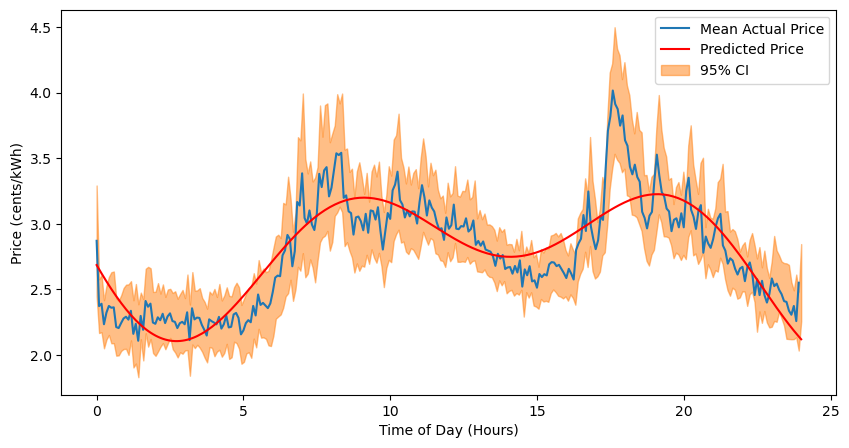

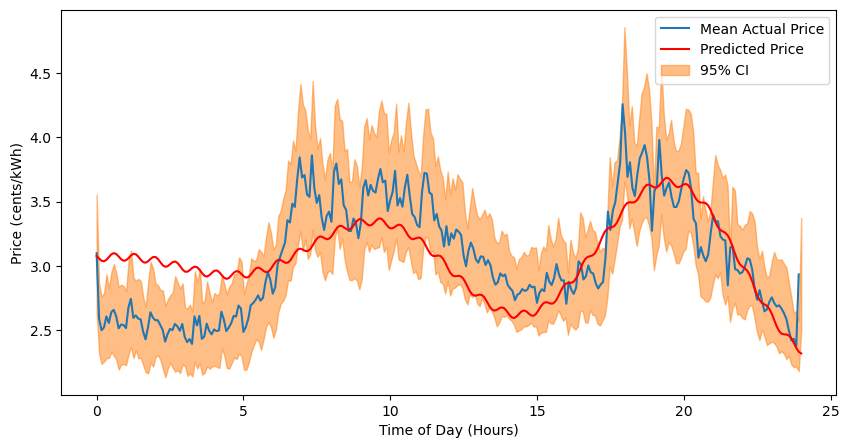

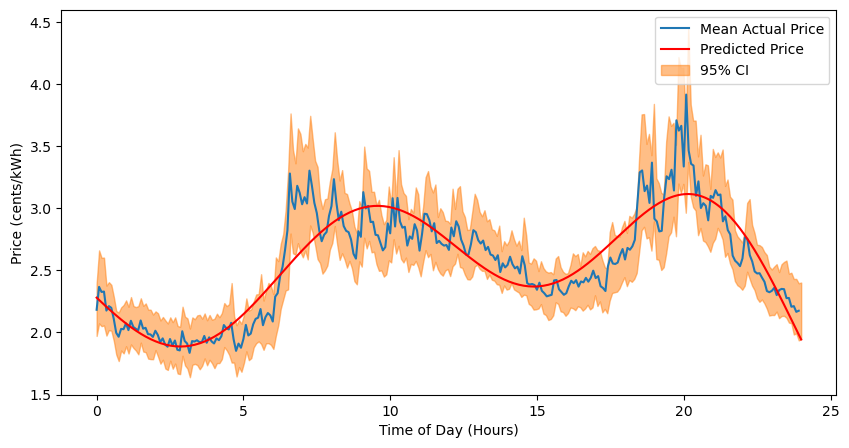

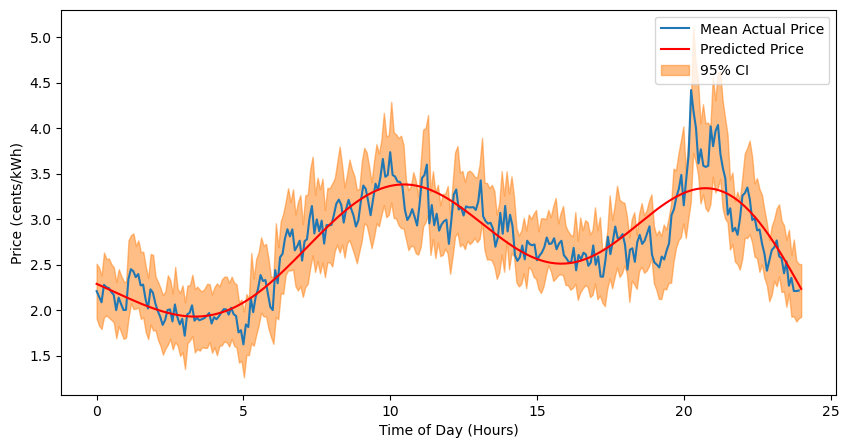

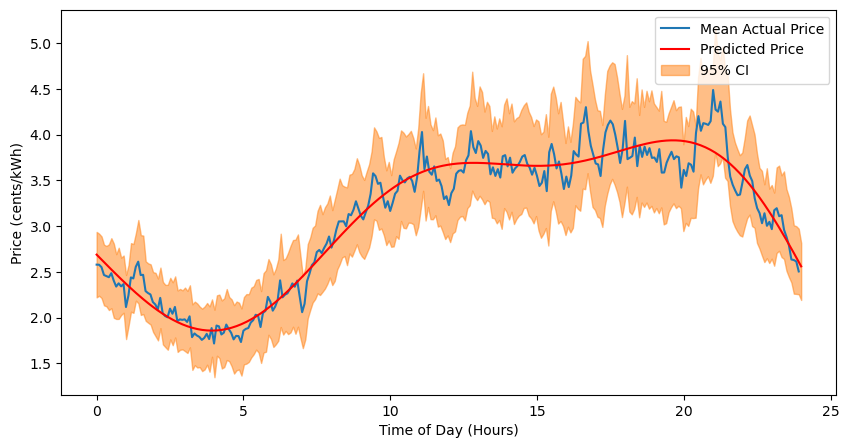

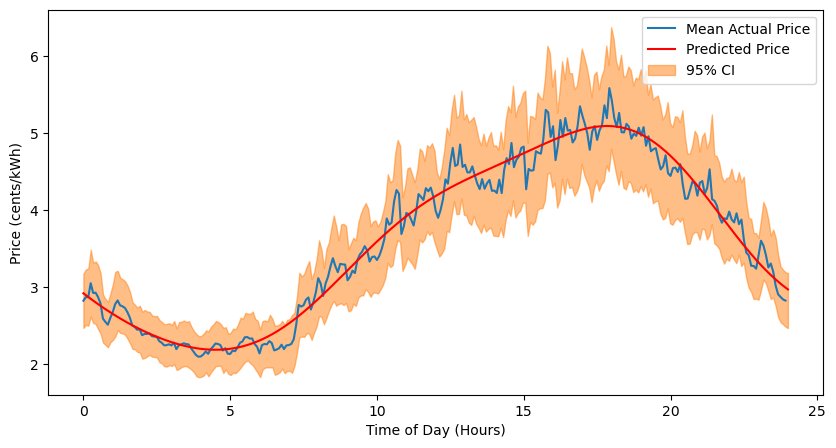

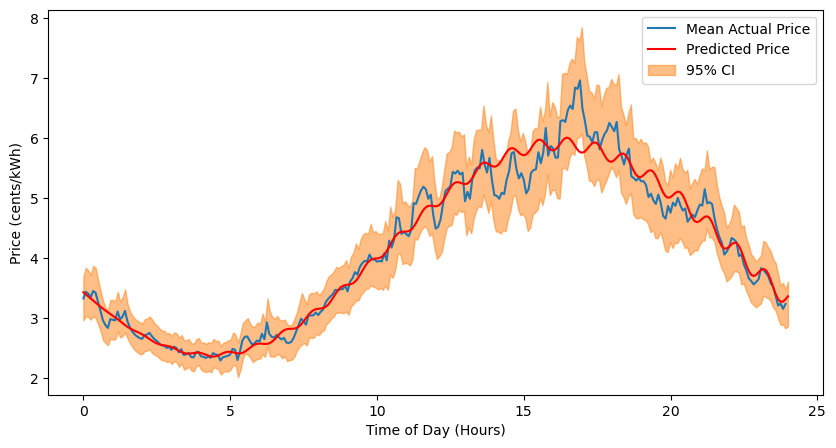

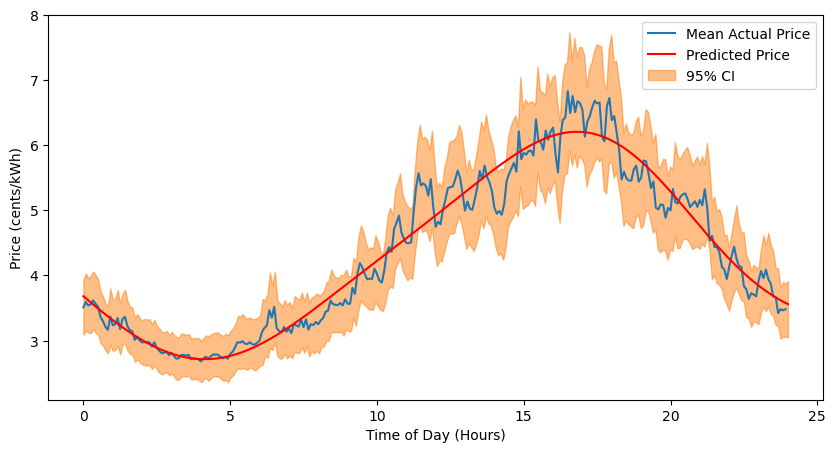

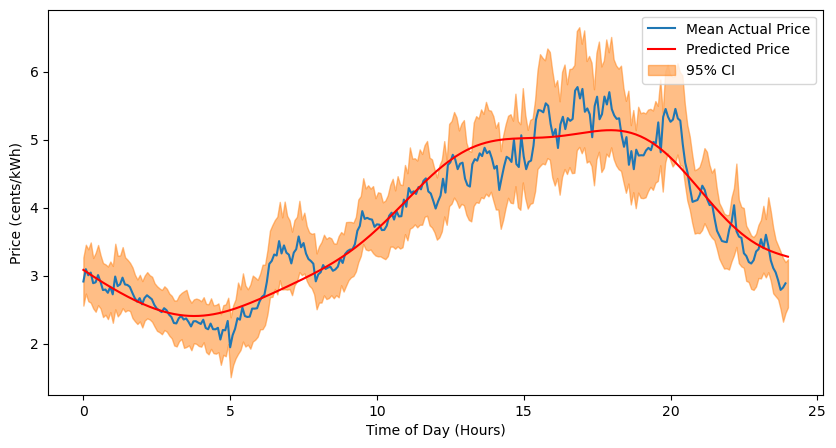

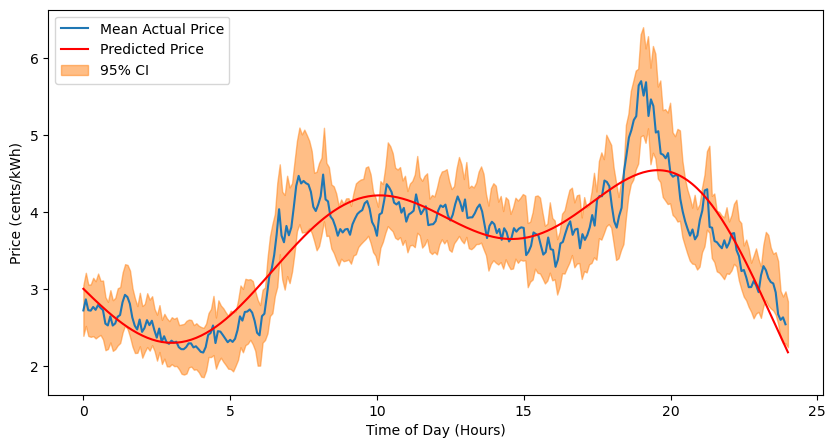

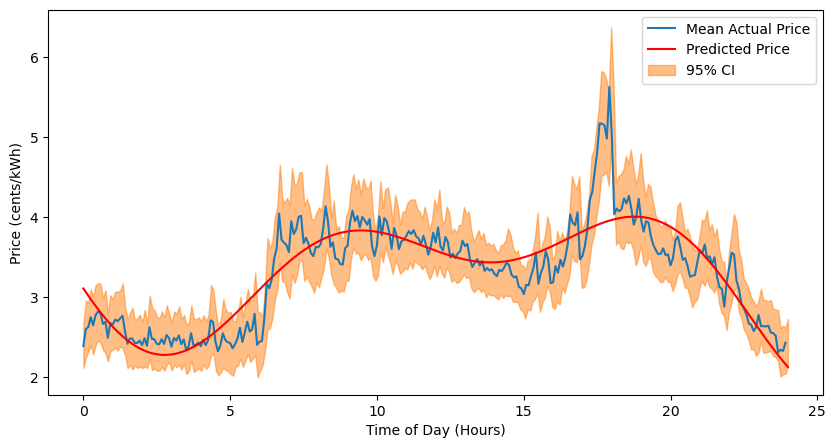

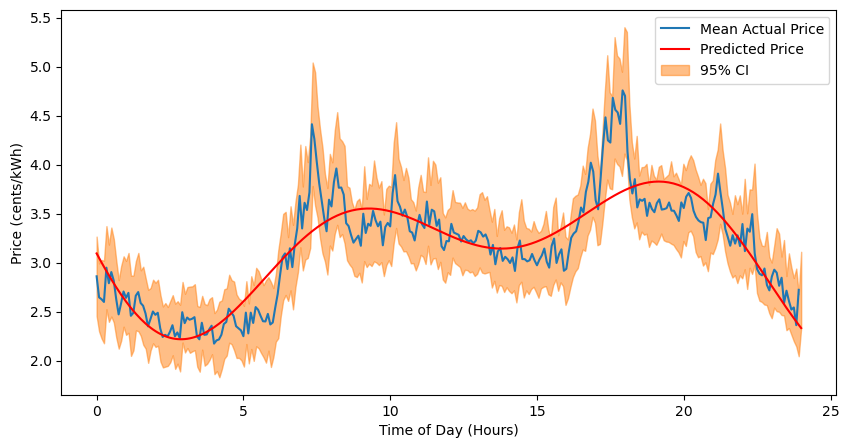

In [176]:
#Calculate MSE and generate historical plots for each month
for i in range(1,13):
    generate_historical_model(i)

Mean Squared Error: 0.0299
Mean Squared Error: 0.0329
Mean Squared Error: 0.0329
Mean Squared Error: 0.0326
Mean Squared Error: 0.0236
Mean Squared Error: 0.0190
Mean Squared Error: 0.0131


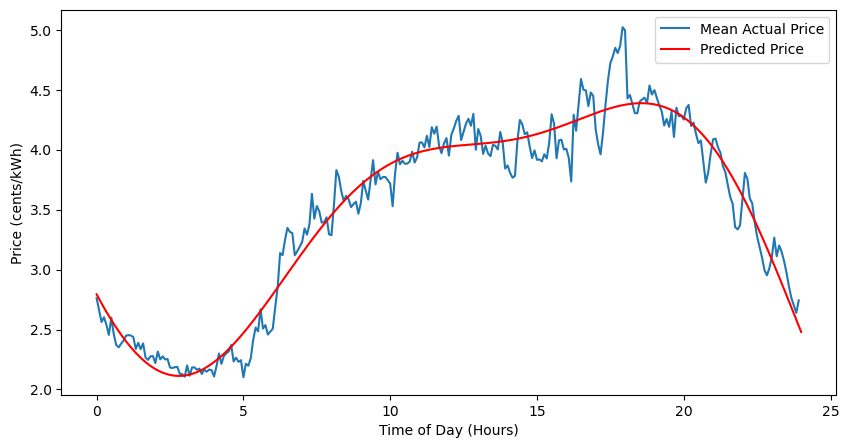

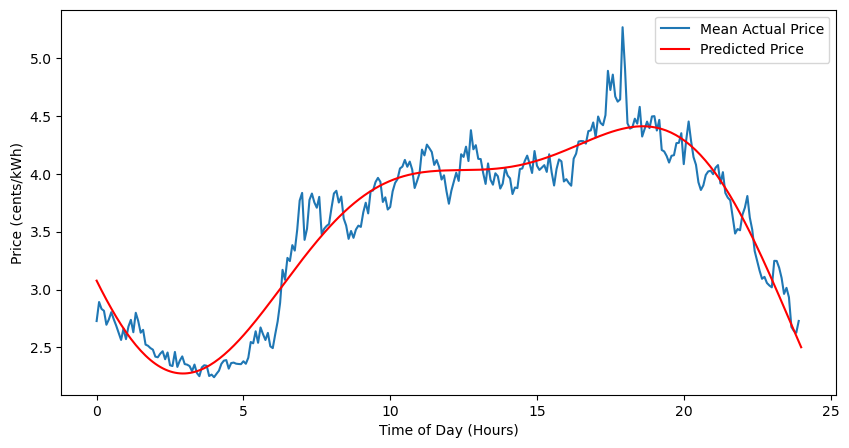

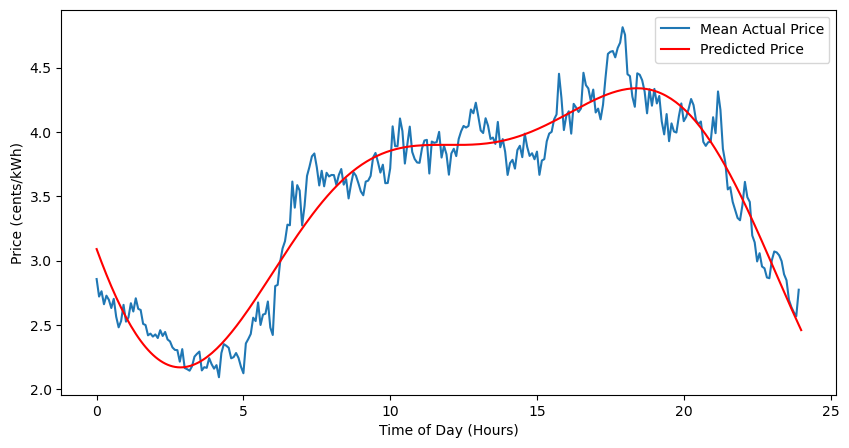

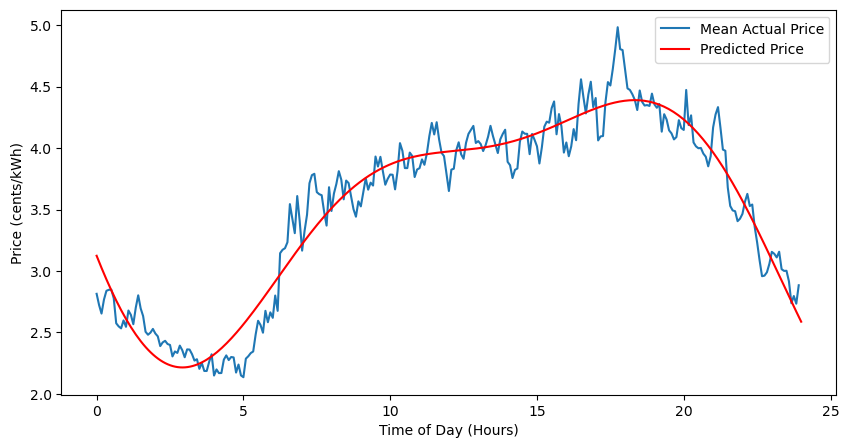

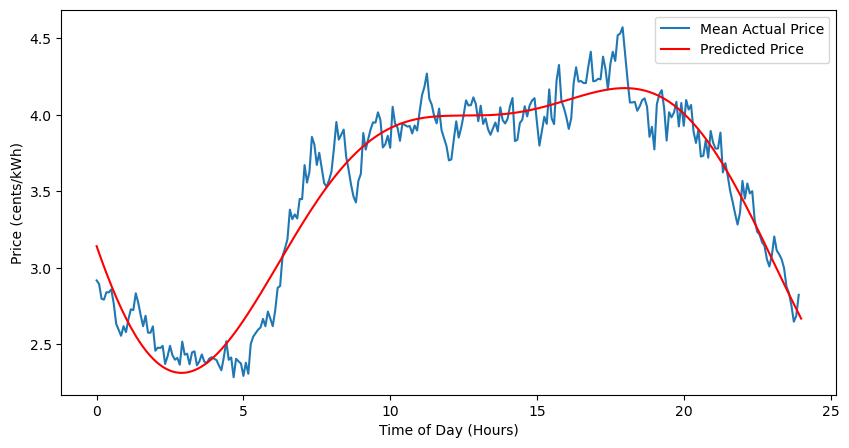

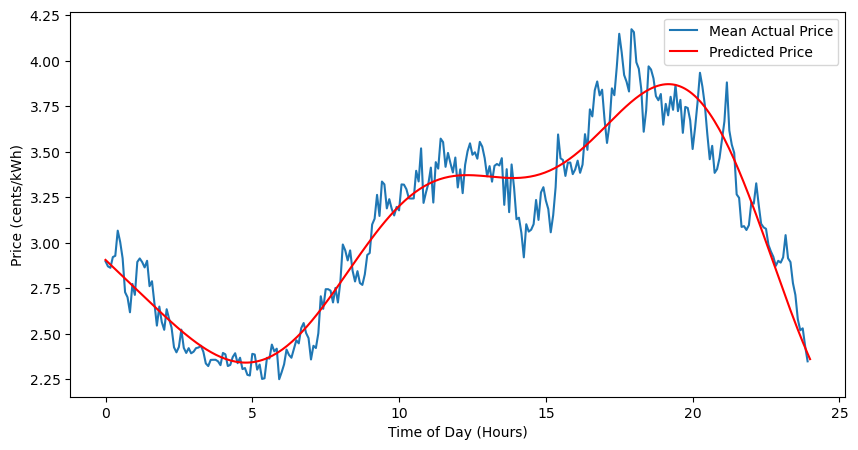

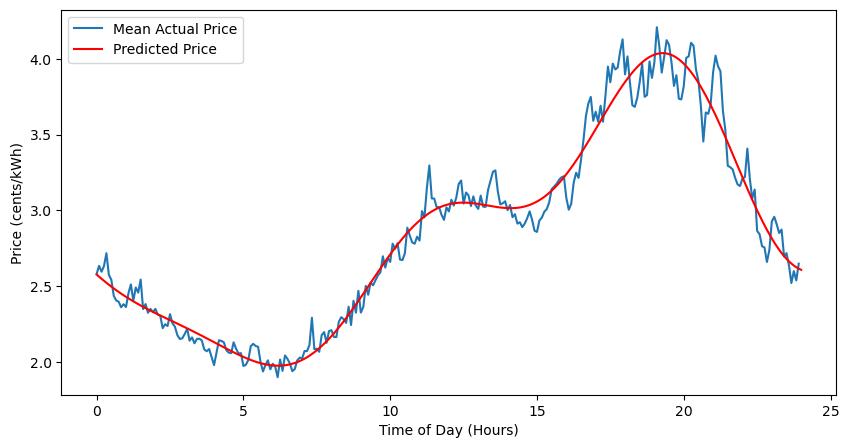

In [149]:
weekdays = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
x = np.linspace(0,24,288)
for day in weekdays:
    p_x = generate_weekday_model(x,day)
    day_df = historical_data[historical_data["weekday"] == day]
    plt.figure(figsize=(10,5))
    #plt.scatter(jan_df["decimal time"], jan_df["price"], label="Actual Price", color="tab:blue")
    day_avg = day_df.groupby("decimal time").mean()["price"]
    plt.plot(day_avg.index, day_avg, label="Mean Actual Price", color="tab:blue")
    plt.plot(x, p_x, label="Predicted Price", color="r")
    plt.xlabel("Time of Day (Hours)")
    plt.ylabel("Price (cents/kWh)")
    plt.legend()

    day_mse = np.mean((p_x-day_avg)**2)
    print("Mean Squared Error: {:.4f}".format(day_mse))

Mean Squared Error: 2.3317 cents
Mean Absolute Error: 1.3059 cents


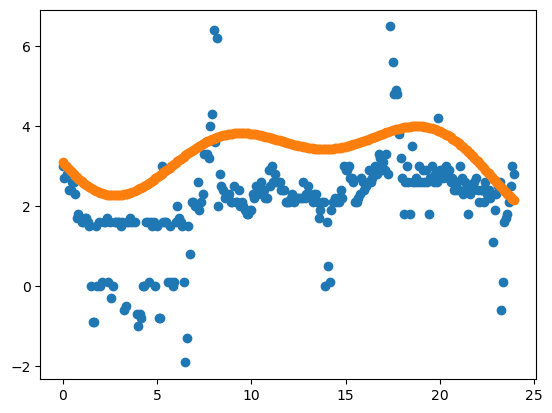

In [165]:
month = now.strftime("%m")
month_predictions = generate_month_model(display_data["decimal time"], int(month))
plt.scatter(display_data["decimal time"], display_data["price"], label="Actual Price",color="tab:blue")
plt.scatter(display_data["decimal time"], month_predictions, label="Predicted Price", color="tab:orange")

current_mse = np.mean((month_predictions-display_data["price"])**2)
current_mae = np.mean(abs(month_predictions-display_data["price"]))
print("Mean Squared Error: {:.4f} cents".format(current_mse))
print("Mean Absolute Error: {:.4f} cents".format(current_mae))

### Backtest

Text(0, 0.5, 'Cents')

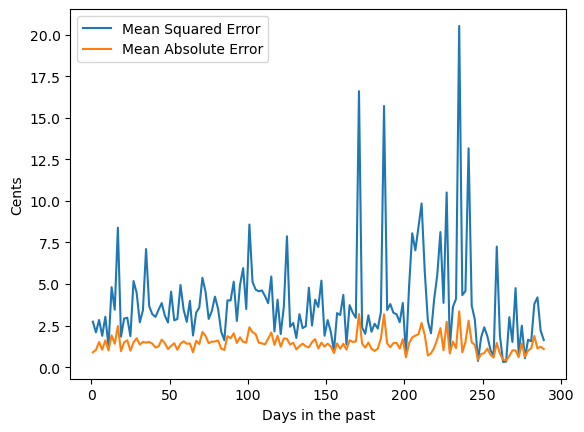

In [153]:
mse = []
mae = []
back_int = np.arange(1,290,2)

for i in back_int:
    now = datetime.datetime.now() - datetime.timedelta(days=int(i)) #Examine model performance for each 2-day interval in 2023
    int_start = now - datetime.timedelta(days=1, hours=1) #Dealing with weirdness of API calls
    int_start_str = int_start.strftime("%Y%m%d%H%M")
    now_str = now.strftime("%Y%m%d%H%M")
    display_data = load_price_data("https://hourlypricing.comed.com/api?type=5minutefeed&datestart="+int_start_str+"&dateend="+now_str)
    month = now.strftime("%m")
    predictions = generate_month_model(display_data["decimal time"], int(month))
    mse.append(np.mean((predictions-display_data["price"])**2))
    mae.append(np.mean(abs(predictions-display_data["price"])))

plt.plot(back_int, mse, label="Mean Squared Error")
plt.plot(back_int, mae, label="Mean Absolute Error")
plt.legend()
plt.xlabel("Days in the past")
plt.ylabel("Cents")

### Hourly Model

The above model was attempting to predict the price at 5-minute intervals, which makes it more sensitive to outliers. As a result the model is modified to only predict the hourly average price.

Mean Squared Error: 1.7541 cents
Mean Absolute Error: 1.2404 cents


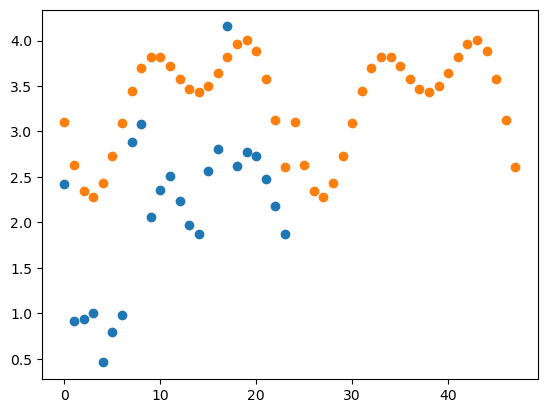

In [157]:
now = datetime.datetime.now()
int_start = now - datetime.timedelta(days=1, hours=1) #Dealing with weirdness of API calls
int_start_str = int_start.strftime("%Y%m%d%H%M")
now_str = now.strftime("%Y%m%d%H%M")
display_data = load_price_data("https://hourlypricing.comed.com/api?type=5minutefeed&datestart="+int_start_str+"&dateend="+now_str)
hourly_data = display_data.groupby("hour").mean()

month = now.strftime("%m")
predictions = generate_month_model(hourly_data.index, int(month))
plt.scatter(hourly_data.index, hourly_data["price"], label="Actual Price",color="tab:blue")
#Hack to get plot looking how we want for display
display_times = list(hourly_data.index)
display_times.extend(hourly_data.index+24)
display_pred = list(predictions)*2
plt.scatter(display_times, display_pred, label="Predicted Price", color="tab:orange")

current_mse = np.mean((predictions-hourly_data["price"])**2)
current_mae = np.mean(abs(predictions-hourly_data["price"]))
print("Mean Squared Error: {:.4f} cents".format(current_mse))
print("Mean Absolute Error: {:.4f} cents".format(current_mae))